# Прогнозирование и кластеризация
**Описание проекта**

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию
взаимодействия с пользователями на основе аналитических данных. Задача — провести анализ и подготовить план действий по удержанию клиентов.

### Оглавление  <a id="0"></a>
[Загрузка и предобработка данных](#1)  

[Исследовательский анализ данных](#2)

[Модель прогнозирования оттока пользователей](#3)  
- [Подготовка выборок](#3_1)
- [Логистическая регрессия](#3_2)
- [Случайный лес](#3_3)
- [Сравнение результатов моделей](#3_4)

[Кластеризация пользователей](#4)

[Общий вывод и рекомендации](#5)

## Загрузка данных <a id="1"></a>   [↑](#0)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
df = pd.read_csv("C:\\Users\\Admin\\Documents\\temp\\gym_churn.csv")
#df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
df.shape

(4000, 14)

In [4]:
df[:2]

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0


**Описание данных**  

Текущие поля в датасете:  
'Churn' — факт оттока в текущем месяце;  
Данные пользователя за предыдущий до проверки факта оттока месяц:  
'gender' — пол;  
'Near_Location' — проживание или работа в районе, где находится фитнес-центр;  
'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);  
Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);  
'Phone' — наличие контактного телефона;  
'Age' — возраст;  
'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах);  
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:  
'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);  
'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);  
'Group_visits' — факт посещения групповых занятий;  
'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;  
'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;  
'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

## Исследовательский анализ данных <a id="2"></a>   [↑](#0)

Переименовываю столбцы, убирая заглавные буквы и сокращая названия для удобства работы с таблицей:

In [5]:
df.columns = df.columns.str.lower()
df.columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period',
              'group_visits', 'age', 'avg_add_charges', 'month_to_end', 'lifetime',
               'avg_frequency', 'avg_frequency_curr', 'churn']

Проверяю наличие дубликатов:

In [6]:
len(df[df.duplicated() == True])

0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              4000 non-null   int64  
 1   near_location       4000 non-null   int64  
 2   partner             4000 non-null   int64  
 3   promo_friends       4000 non-null   int64  
 4   phone               4000 non-null   int64  
 5   contract_period     4000 non-null   int64  
 6   group_visits        4000 non-null   int64  
 7   age                 4000 non-null   int64  
 8   avg_add_charges     4000 non-null   float64
 9   month_to_end        4000 non-null   float64
 10  lifetime            4000 non-null   int64  
 11  avg_frequency       4000 non-null   float64
 12  avg_frequency_curr  4000 non-null   float64
 13  churn               4000 non-null   int64  
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Типы данных корректны. Большая часть столбцов могла бы иметь вид boolean, но для машинного обучения представление в виде 1 и 0 корректно. Смотрю статистические показатели датасета:

In [8]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_add_charges,month_to_end,lifetime,avg_frequency,avg_frequency_curr,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Все показатели - минимальные и максимальные значения, отношение среднего к медиане - выглядят корректно. Проверяю значения по отдельным столбцам.  
Столбцы с логическими значениями: 

In [9]:
[print(df[i].unique()) for i in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']]

[1 0]
[1 0]
[1 0]
[1 0]
[0 1]
[1 0]
[0 1]


[None, None, None, None, None, None, None]

Все логические столбцы имеют значения только 1 и 0.  

Проверяю данные, которые выражены в месяцах:

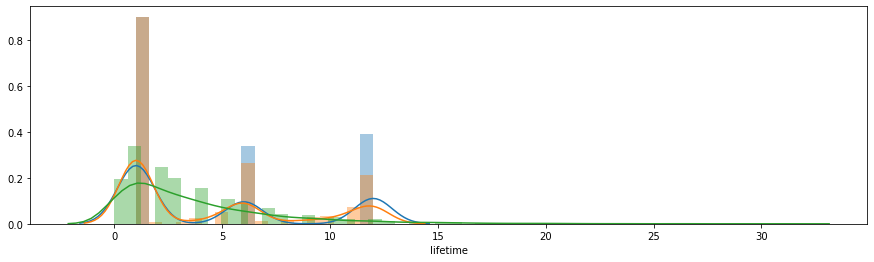

In [10]:
plt.figure(figsize=(15, 4))
[sns.distplot(df[i]) for i in ['contract_period', 'month_to_end', 'lifetime']]

Распределение 'lifetime' - времени с момента первого обращения в фитнес-центр - нормальное;  
'contract_period' - длительность абонемента - принимает значения только 1, 6 и 12 месяцев, что корректно, хотя в описании также доступны 9 месяцев;  
'month_to_end' - срок до окончания абонемента - имеет пики на 1, 6 и 12 месяцах, хотя должен также иметь нормальное распределение. Это может быть вызвано, например, тем, что данные установлены в момент покупки абонемента и не обновляются. Проверяю: 

In [11]:
len(df.query('contract_period == month_to_end'))/len(df)

0.8405

Для 84% анкет срок абонемента равен сроку до окончания абонемента, что подтверждает, что данные не обновлялись с момента покупки и некорректны. В дальнейшем я не буду использовать срок до окончания абонемента.

Проверяю значения возраста:

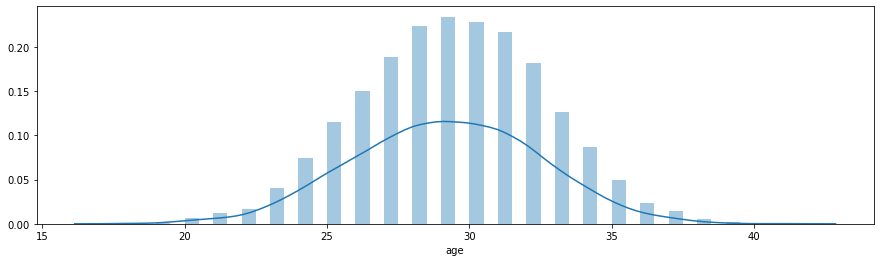

In [12]:
plt.figure(figsize=(15, 4))
sns.distplot(df['age'])

Суммарной выручки от других услуг фитнес-центра:

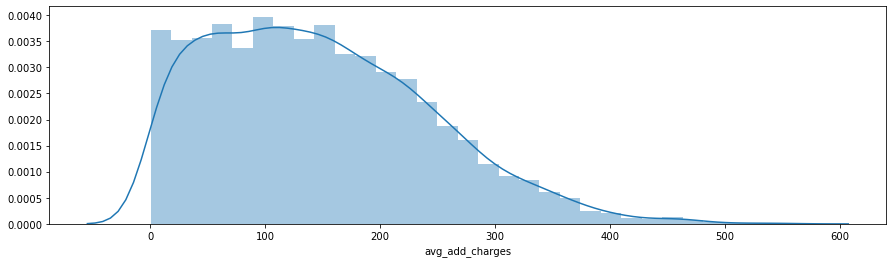

In [13]:
plt.figure(figsize=(15, 4))
sns.distplot(df['avg_add_charges'])

Средней частоты посещений в неделю за все время и за предыдущий месяц:

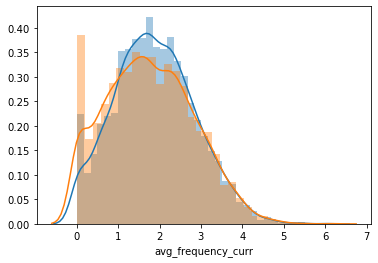

In [14]:
[sns.distplot(df[i]) for i in ['avg_frequency', 'avg_frequency_curr']]

Эти данные имеют ожидаемое распределение в корректных пределах.  
  
Оцениваю средние значения признаков в двух группах - ушедших и оставшихся клиентов:

In [15]:
df.groupby('churn').mean().transpose().join(pd.DataFrame({'total': df.mean()}))

,0,1,total
gender,0.510037,0.510839,0.510250
near_location,0.873086,0.768143,0.845250
partner,0.534195,0.355325,0.486750
promo_friends,0.353522,0.183789,0.308500
phone,0.903709,0.902922,0.903500
contract_period,5.747193,1.728558,4.681250
group_visits,0.464103,0.268615,0.412250
age,29.976523,26.989632,29.184250
avg_add_charges,158.445715,115.082899,146.943728
month_to_end,5.283089,1.662582,4.322750


Неудивительно, что реже уходят клиенты, которые:  
- живут рядом, 
- имеют скидку от работодателя, 
- у которых есть друзья в клубе, 
- с более длительным абонементом и которые раньше пришли в фитнес-центр ('lifetime'),
- больше тратят денег на прочие услуги (что зависит от количества посещений);
- чаще посещают фитнес-центр (причем особенно в последний месяц).  

Менее очевидно и более интересно:
- чаще уходят клиенты возраста ниже среднего (27 лет против 30 у тех, кто остался);  
- отток ниже у тех, кто посещает групповые занятия (это может коррелировать с посещениями финтнес-центра в целом, однако, возможно, групповые занятия несут дополнительную ценность);
- пол и желание предоставить свой телефон фитнес-центру, похоже, не влияют на отток.  

Для всех небулевых столбцов (кроме 'month to end', так как он неинформативен) строю гистограммы распределения по признаку оттока клиента: 

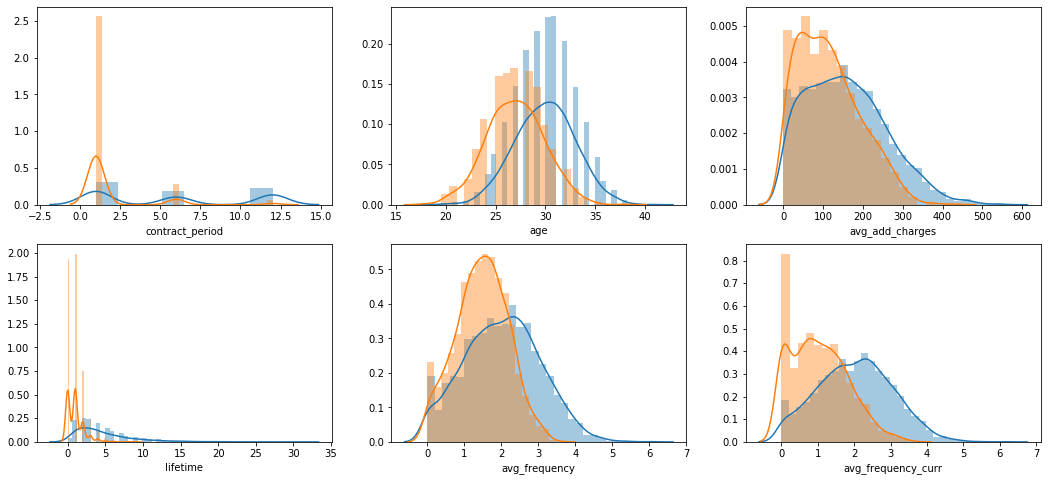

In [16]:
i = 0
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (18,8))
for column in ['contract_period', 'age', 'avg_add_charges', 'lifetime', 'avg_frequency', 'avg_frequency_curr']:
    sns.distplot(df.query('churn == 0')[column], ax = axes[i//3, (i)%3])
    sns.distplot(df.query('churn == 1')[column], ax = axes[i//3, (i)%3])
    i += 1
plt.show()

Графики подтверждают выводы, сделанные выше. По двум левым графикам (срок абонемента и время с момента первого обращения) заметно, что значительная часть оттока - это новые клиенты, которые в первый (и последний) раз взяли абонемент на 1 месяц.  
Для оценки признаков, которые можно использовать для прогноза оттока, строю матрицу корреляции:

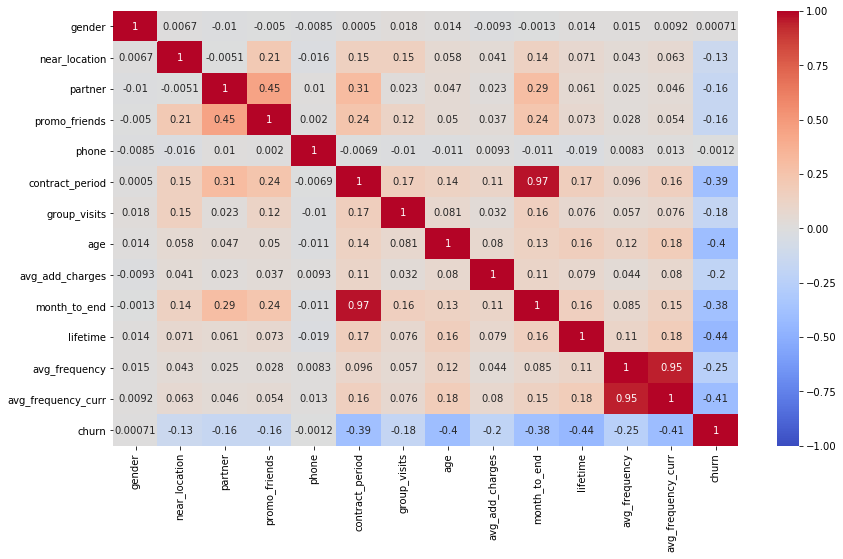

In [17]:
plt.figure(figsize=(14, 8))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, cmap="coolwarm")

Выводы по матрице:  
хотя бы слабая (<-0,3) отрицательная корреляция есть только у оттока, что ожидаемо;
хотя бы слабая (> 0,3) положительная корреляция есть между:
- partner и promo_friens - вероятно, сотрудники одной компании приглашают друг друга, корреляция слабая, чтобы корректировать ее при прогнозе;
- partner и contract_period - более долгосрочные абонементы для сотрудников со скидкой от работодателя;
- contract_period и month_to_end - уже ранее отмеченная ошибка;
- средняя частота посещений за все время и за последний месяц. Так как эти показатели коррелируют на 95%, для модели прогноза необходимо оставить только один из них. Как было отмечено по средним значениям частоты посещений ранее (а также исходя из корреляции этих показателей с оттоком), последний месяц посещений значительно более показателен для предсказания оттока, поэтому для модели прогноза на следующий месяц следует оставить его.  

Удаляю из датасета два лишних для прогнозирования столбца:

In [18]:
df = df.drop(['month_to_end', 'avg_frequency'], axis = 1)

## Модель прогнозирования оттока пользователей <a id="3"></a>  [↑](#0)  
В соответствии с заданием, для прогнозирования я буду сравнивать методы (1) логистической регрессии и (2) случайного леса. 

### Подготовка выборок <a id="3_1"></a>  [↑](#0)  

Так как оба метода допускают настройки параметров модели, я разделяю датасет на три части:  
- обучающую (train) для обучения моделей - 60%
- валидационную (validate) для настройки и выбора параметров модели - 20% 
- тестовую (test) для проверки качества и сравнения моделей - 20%  

In [19]:
X = df.drop('churn', axis = 1)
y = df['churn']
X_train, X_vt, y_train, y_vt = train_test_split(X, y, test_size=0.4, random_state = 42)
X_validate, X_test, y_validate, y_test = train_test_split(X_vt, y_vt, test_size=0.5, random_state = 42)
for sample in [X_train, y_train, X_validate, y_validate, X_test, y_test]:
    print(sample.shape)

(2400, 11)
(2400,)
(800, 11)
(800,)
(800, 11)
(800,)


Стандартизирую все выборки на основе обучающей:

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_validate_st = scaler.transform(X_validate)
X_test_st = scaler.transform(X_test)

### Логистическая регрессия <a id="3_2"></a>  [↑](#0)  
Обучаю модель и применяю к тестовой выборке:

In [21]:
model_LR = LogisticRegression(random_state = 42)
model_LR.fit(X_train_st, y_train)
probabilities_LR = model_LR.predict_proba(X_validate_st)[:,1]

Так как уровень оттока клиентов около 26%, модель может предсказывать менее точно при пороге в 50%, поэтому я проверяю ее работу для всех порогов от 0,1 до 0,9:

In [22]:
results_LR = pd.DataFrame(columns=['threshold', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
for i in range(1,10):
    threshold = i/10
    predictions_LR = [0 if i < threshold else 1 for i in probabilities_LR]
    accuracy = accuracy_score(y_validate, predictions_LR)
    precision = precision_score (y_validate, predictions_LR)
    recall = recall_score (y_validate, predictions_LR)
    f1 = f1_score(y_validate, predictions_LR)
    roc_auc = roc_auc_score(y_validate, predictions_LR)
    results_LR = results_LR.append(pd.DataFrame(
        data = {'threshold':[threshold], 'accuracy':[accuracy], 'precision':[precision], 'recall':[recall], 
                'f1':[f1], 'roc_auc':[roc_auc]}), ignore_index = True)

In [23]:
pd.options.display.float_format = '{:.1%}'.format
results_LR

,threshold,accuracy,precision,recall,f1,roc_auc
0,10.0%,84.1%,63.1%,97.2%,76.5%,88.3%
1,20.0%,88.2%,70.9%,94.8%,81.1%,90.3%
2,30.0%,89.9%,75.8%,91.1%,82.7%,90.3%
3,40.0%,91.4%,82.4%,85.9%,84.1%,89.6%
4,50.0%,91.6%,85.8%,82.2%,83.9%,88.6%
5,60.0%,91.0%,87.7%,77.0%,82.0%,86.5%
6,70.0%,90.6%,92.6%,70.4%,80.0%,84.2%
7,80.0%,89.1%,95.7%,62.0%,75.2%,80.5%
8,90.0%,84.5%,97.8%,42.7%,59.5%,71.2%


Оцениваю результаты работы модели. Точность модели с точки зрения чистого моделирования показывает метрика accuracy ((TP + TN) / n). Однако, учитывая, что задача от бизнеса звучит как "научиться прогнозировать вероятность оттока", recall (TP / (TP + TN)) важнее, чем precision, так как recall показывает, какую долю ушедших клиентов удалось предсказать заранее, а если модель покажет ложноположительную вероятность ухода клиента, это не принесет бизнесу лишних затрат. При этом при выборе порога важно, чтобы все метрики (precision, f1, roc_auc) не проседали.  
В итоге: accuracy достигает максимальных значений на уровне 0,3-0,6, f1 0,2-0,4, roc_auc 0,1-0,3. Между противоположными по сути метриками recall и precision важнее с точки зрения бизнеса recall. Поэтому я выбираю в качестве порога уровень 0,3. С этим уровнем я и формирую итоговый результат работы модели на валидационной выборке:

In [24]:
def model_results(y_true, predictions):
    print(confusion_matrix(y_true, predictions).ravel())
    print('Accuracy: {:.2f}'.format(accuracy_score(y_true, predictions)))
    print('Precision: {:.2f}'.format(precision_score (y_true, predictions)))
    print('Recall: {:.2f}'.format(recall_score (y_true, predictions)))
    print('F1: {:.2f}'.format(f1_score (y_true, predictions)))
    print('AUC-ROC: {:.2f}'.format(roc_auc_score (y_true, predictions)))

In [25]:
threshold = 0.3
predictions_LR = [0 if i < threshold else 1 for i in probabilities_LR]
model_results(y_validate, predictions_LR)

[525  62  19 194]
Accuracy: 0.90
Precision: 0.76
Recall: 0.91
F1: 0.83
AUC-ROC: 0.90


#### Случайный лес  <a id="3_3"></a>  [↑](#0)  

Чтобы проверить, насколько влияет количество деревьев в лесу на итоговый результат, строю модель для разного количества деревьев:

In [26]:
results_RF = pd.DataFrame(columns=['n_estimators', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
for i in [10,100,1000]:
    model_RF = RandomForestClassifier(n_estimators = i, random_state = 42)
    model_RF.fit(X_train_st, y_train)
    predictions_RF = model_RF.predict(X_validate_st)
    accuracy = accuracy_score(y_validate, predictions_RF)
    precision = precision_score (y_validate, predictions_RF)
    recall = recall_score (y_validate, predictions_RF)
    f1 = f1_score(y_validate, predictions_RF)
    roc_auc = roc_auc_score(y_validate, predictions_RF)
    results_RF = results_RF.append(pd.DataFrame(
        data = {'n_estimators':[i], 'accuracy':[accuracy], 'precision':[precision], 'recall':[recall], 
                'f1':[f1], 'roc_auc':[roc_auc]}), ignore_index = True)

In [27]:
results_RF

,n_estimators,accuracy,precision,recall,f1,roc_auc
0,10,89.8%,84.3%,75.6%,79.7%,85.2%
1,100,90.2%,83.6%,78.9%,81.2%,86.6%
2,1000,90.4%,83.7%,79.3%,81.4%,86.9%


При увеличении количества деревьев со 100 до 1000 качество модели не меняется, поэтому я выбираю n_estimators, равный 100:

In [28]:
model_RF = RandomForestClassifier(n_estimators = 100, random_state = 42)
model_RF.fit(X_train_st, y_train)
predictions_RF = model_RF.predict(X_validate_st)
model_results(y_validate, predictions_RF)

[554  33  45 168]
Accuracy: 0.90
Precision: 0.84
Recall: 0.79
F1: 0.81
AUC-ROC: 0.87


### Сравнение моделей на тестовой выборке <a id="3_4"></a>  [↑](#0)  

In [29]:
results = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [30]:
probabilities_LR_test = model_LR.predict_proba(X_test_st)[:,1]
threshold = 0.3
predictions_LR_test = [0 if i < threshold else 1 for i in probabilities_LR_test]
accuracy = accuracy_score(y_test, predictions_LR_test)
precision = precision_score (y_test, predictions_LR_test)
recall = recall_score (y_test, predictions_LR_test)
f1 = f1_score(y_test, predictions_LR_test)
roc_auc = roc_auc_score(y_test, predictions_LR_test)
results = results.append(pd.DataFrame(
                data = {'model':['Логистическая регрессия'], 'accuracy':[accuracy], 'precision':[precision], 'recall':[recall], 
                'f1':[f1], 'roc_auc':[roc_auc]}), ignore_index = True)

In [31]:
predictions_RF_test = model_RF.predict(X_test_st)
accuracy = accuracy_score(y_test, predictions_RF_test)
precision = precision_score (y_test, predictions_RF_test)
recall = recall_score (y_test, predictions_RF_test)
f1 = f1_score(y_test, predictions_RF_test)
roc_auc = roc_auc_score(y_test, predictions_RF_test)
results = results.append(pd.DataFrame(
                data = {'model':['Случайный лес'], 'accuracy':[accuracy], 'precision':[precision], 'recall':[recall], 
                'f1':[f1], 'roc_auc':[roc_auc]}), ignore_index = True)

In [32]:
results

,model,accuracy,precision,recall,f1,roc_auc
0,Логистическая регрессия,90.8%,75.0%,93.4%,83.2%,91.6%
1,Случайный лес,90.4%,82.9%,76.5%,79.6%,85.7%


Вывод: модель логистической регрессии на тестовой выборке показала более высокие результаты по сравнению и с моделью случайного леса, и с собой же на валидационной выборке. Ключевой показатель для бизнеса - recall, и общая точность модели (accuracy) - на уровне выше 90%, что можно считать успешным результатом. Случайный лес, наоборот, на тестовой выборке показал результаты хуже, чем на валидационной.

## Кластеризация пользователей <a id="4"></a>  [↑](#0)  

Стандартизирую датасет:

In [33]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
linked = linkage(X_sc, method = 'ward')

Строю дендрограмму иерархической кластеризации:

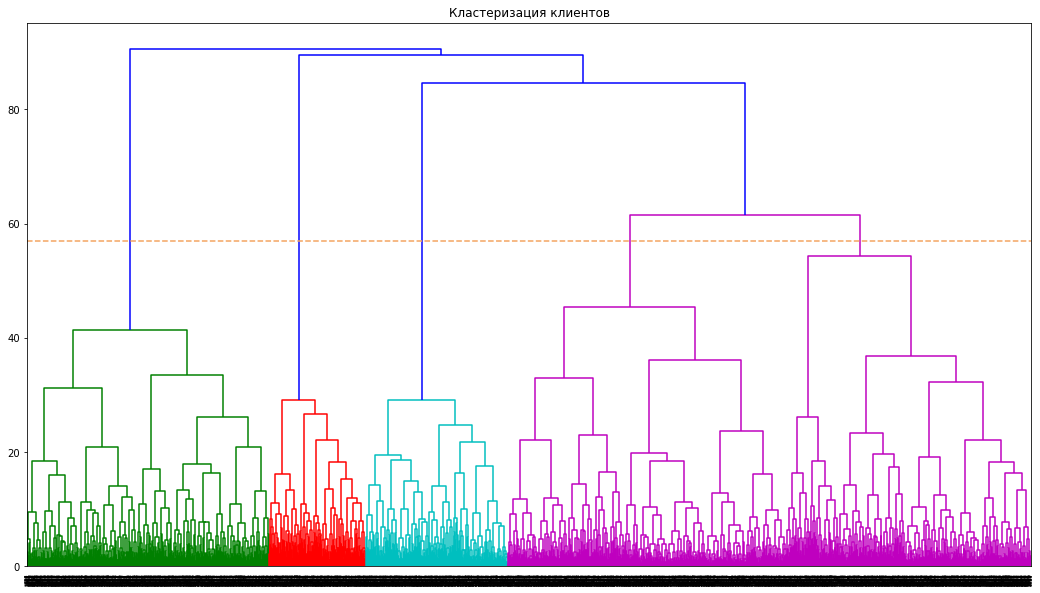

In [34]:
plt.figure(figsize=(18, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов')
plt.axhline(y=57, color='sandybrown', linestyle='--')
plt.show()

Дендрограмма предлагает 4 кластера, однако, учитывая, что половина клиентов попала в один кластер, можно выделить 5 или 6 кластеров. В соответствии с заданием, выделяю 5 кластеров (условно можно считать этот выбор обозначенным оранжевой линией), и формирую 5 кластеров методом К средних:

In [35]:
pd.options.display.float_format = '{:.2f}'.format
km = KMeans(n_clusters = 5, random_state = 42)
labels = km.fit_predict(X_sc)
df['cluster_km'] = labels

Вывожу средние значения признаков для кластеров и добавляю размер каждого кластера:

In [36]:
clusters = df.groupby('cluster_km')\
            .agg('mean')\
            .join(pd.DataFrame({'size': df.groupby('cluster_km')['gender'].count()}), on = 'cluster_km')
clusters

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_add_charges,lifetime,avg_frequency_curr,churn,size
cluster_km,,,,,,,,,,,,,
0,0.50,0.00,0.49,0.08,1.00,2.99,0.23,28.68,137.13,2.97,1.60,0.40,558
1,0.50,1.00,0.20,0.06,1.00,1.96,0.31,27.75,122.64,1.97,1.25,0.54,1116
2,0.50,1.00,0.89,1.00,1.00,6.89,0.52,29.58,153.07,4.26,1.91,0.12,990
3,0.54,1.00,0.41,0.01,1.00,6.53,0.52,30.70,175.99,5.58,2.34,0.01,950
4,0.52,0.86,0.47,0.31,0.00,4.78,0.43,29.30,144.21,3.94,1.72,0.27,386


Рассматриваю графики распределения параметров по кластерам:

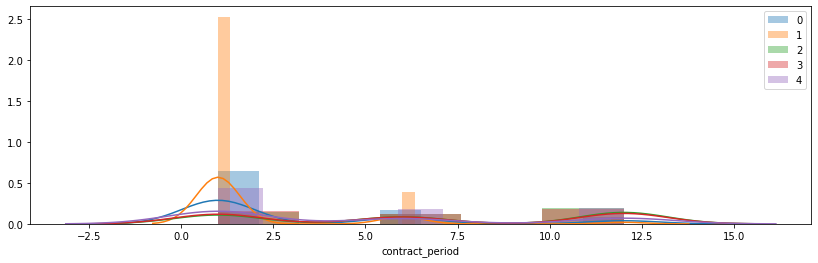

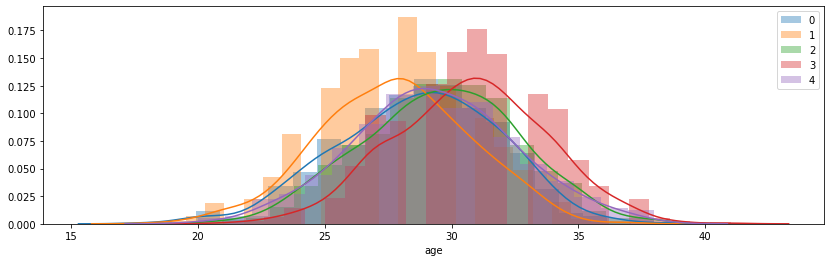

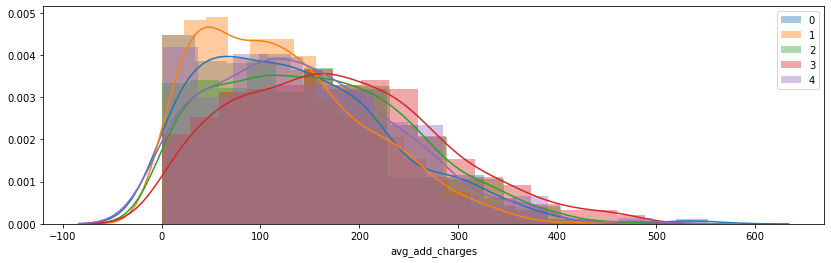

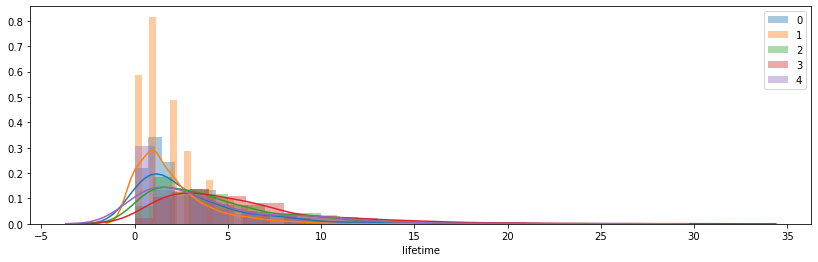

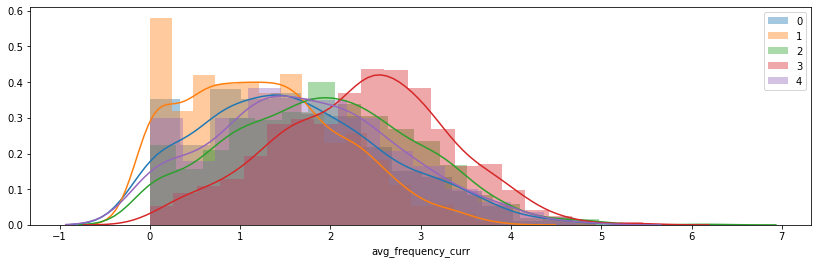

In [37]:
for column in ['contract_period', 'age', 'avg_add_charges', 'lifetime', 'avg_frequency_curr']:
    plt.figure(figsize=(14, 4))
    for cluster in range(0,5):
        sns.distplot(df[df['cluster_km'] == cluster][column], kde = True, label=cluster)
    plt.legend()    
    plt.show()

Для бинарных параметров строю графики по средним значениям:

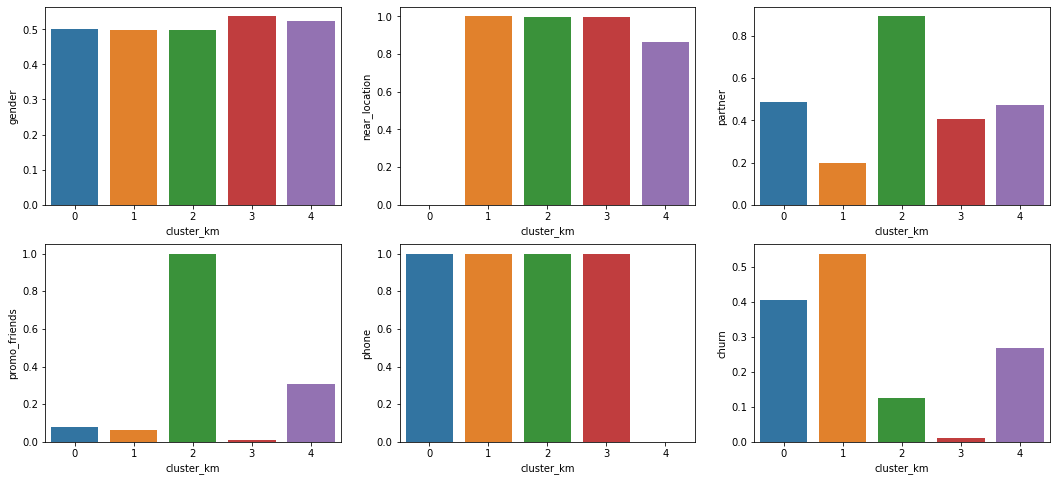

In [38]:
data = clusters.reset_index()
i = 0
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (18,8))
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'churn']:
    sns.barplot(x = 'cluster_km', y = column, data = data, ax = axes[i//3, (i)%3])
    i += 1
plt.show()

Можно сделать выводы, как были сформированы отдельные кластеры:  
- кластер №0 (первый по порядку) состоит из самых старших клиентов, которые тратят больше денег на дополнительные услуги, пришли в клуб больше пяти лет назад, живут рядом, преимущественно посещают групповые занятия и приходят больше 2 раз в неделю. Большая их часть пришла не по приглашению друзей или работодателя. Это самая лояльная группа клиентов, неудивительно, что у них самый низкий отток - 3%.
- кластер №1 - самый молодой в плане возраста и времени с первого посещения, эти клиенты редко посещают фитнес-центр. Логично, что и отток самый высокий - 62%.
- кластер №2 (третий по порядку) имеет средние параметры кроме одного - клиенты не живут рядом с фитнес-центром. Высокий отток в 40% показывает, что это один из самых важных параметров.  
- №3 - группа, пришедшая по приглашению друзей (79%) или предложению работодателя (96%). У большинства годовые абонементы, эти клиенты - вторые по возрасту, частоте посещений посещениям групповых занятий и дополнительным тратам после кластера №0. И, естественно, по оттоку.
- №4 - кластер, составленный из людей, не предоставивших фитнес-центру свой телефон. Как видно по остальным параметрам и оттоку, это второстепенный параметр, никак не характеризующий группу. Таким образом, можно считать, что эта группа - обычные клиенты без существенных признаков.  

*Все счастливые семьи похожи друг на друга, каждая несчастливая семья несчастлива по-своему.* Средние параметры показывают, что две самых лояльных группы клиентов во многом похожи, они отличаются только тем, что одни пришли в фитнес-центр сами, а вторых пригласили друзья или работодатель.  Основной отток приходится на две группы - разовых клиентов с коротким абонементом, почти две трети (62%) которых уходит каждый месяц, и клиентов, которые не живут рядом с фитнес-центром.  

## Общий вывод и рекомендации <a id="5"></a>  [↑](#0)  
  
Из двух сравниваемых моделей логистическая регрессия показала лучшие результаты, чем случайный лес, с показателями accuracy, recall и ROC AUC выше 90% на тестовой выборке. Таким образом, используя модель, можно предсказывать уход посетителя фитнес-центра в следующем месяце с ожидаемой вероятностью 93%. С использованием этой модели клуб может выявлять таких килентов и предлагать им индивидуальные условия, чтобы сохранить хотя бы часть из них. В случае, если работа с такими клиентами будет затратной для клуба (в виде прямых затрат на увеличение персонала для общения с клиентами или недополученной выручки от скидок), можно переобучить модель с приоритетом на precision, а не recall, чтобы сократить долю ложноположительных результатов.  
  
Разделение клиентов на кластеры позволило понять целевой портрет как лояльных, так и, наоборот, уходящих клиентов. В наиболее лояльном кластере отток равен 3%, нет явных факторов для его снижения. Отток в кластере лояльных клиентов, пришедших по приглашению друзей или работодателя, равен 8%, хотя в остальном они похожи на первый кластер. Возможно, они уходят при смене работы и их можно удержать, если предоставить им дополнительную скидку, заменяющую потерю компенсаций от работодателя. Для кластера разовых клиентов с оттоком в 62%, которые впервые купили краткосрочный абонемент и мало им пользуются, можно не создавать специальных мер по удержанию, это нормальный поток людей, которые просто знакомятся с клубом. Для остальных двух кластеров с оттоком в 27% и 40% можно придумать отдельные меры по удержанию: узнать, чего не хватает в фитнес-центре, предоставить скидки для молодых клиентов (например, до 26 лет), продление абонементов. Главную причину оттока - то, что посетители живут не рядом с клубом - решить нельзя, но можно собирать их данные, чтобы понимать, в каком районе можно открыть другой фитнес-центр.